In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Heterogeneous Agents/notebooks/")
# Pkg.add("Plots"); Pkg.add("Optim"); Pkg.add("Interpolations"); Pkg.add("LinearAlgebra")
using Plots; using Interpolations; using LinearAlgebra; using Optim
gr(fmt=:png);
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Heterogeneous Agents\notebooks\Project.toml`


      Status `D:\GitHub\Heterogeneous Agents\notebooks\Project.toml`
  [17a596ad] ChebyshevApprox v0.1.12
  [35d6a980] ColorSchemes v3.15.0
  [31c24e10] Distributions v0.25.11
  [a98d9a8b] Interpolations v0.13.4
  [0db19996] NBInclude v2.2.0
  [429524aa] Optim v1.4.1
  [d96e819e] Parameters v0.12.2
  [91a5bcdd] Plots v1.20.1
  [08abe8d2] PrettyTables v1.1.0
  [f2b01f46] Roots v1.2.0
  [239c3e63] Vega v2.3.0
  [37e2e46d] LinearAlgebra


# Basic Heterogeneous Agents Model at Stationary Equilibrium

- Instantaneous utility function: $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$
- Production: $f(K,N)=K^\alpha N^{1-\alpha}$
- Idiosincraic risk: two state markov chain (employed, unemployed)
- Borrowing limit: $ \underline{a}$
- $r_t = \alpha (N_t/K_t)^{1-\alpha}-\delta$
- Goverment charges $\tau_t$ over income $T_t=\tau(w_tN_t+r_tK_t)$
- Goverment transfers unemployments compensations $b_t$ as a fixed ratio of wages, $b_t=\theta w_t$.
- Goverment zero deficit $T_t=(1-N_{ss})b_t$.


We can conclude that:

- At stationary equilibrium aggregate variables, prices and the asset distribution $f$ are constant
- $N_{ss}$ is determined by the stationary probability of being employed
- $r_t(N_t,K_t) = \alpha (N_t/K_t)^{1-\alpha}-\delta$
- $w_t(N_t,K_t) = (1-\alpha) (K_t/N_t)^\alpha$
- $b_t(N_t,K_t) = \tau(1-N_t)(w_tN_t+r_tK_t)$

Given the probabilities' transition matrix, it is possible to find the stationary probabilities, that define $N_{ss}$.

$K_{ss}$ defines $r_{ss}$ $w_{ss}$ $b_{ss}$

The household problem at the steady state (no need to include $K$ or $N$) is:

$$
V(a,\epsilon) = \max_{\underline{a} \leq a' \leq y(a,\epsilon)}
    \left\{
        u(y(a,\epsilon)-a') + \beta \; \mathbb{E}[ V(a',\epsilon')\,|\epsilon]
    \right\}
$$

Where

$$
a'|e=(1+(1-\tau)r_{ss})a+(1-\tau)w_{ss}-c:=y(a,e)-c
$$

$$
a'|u=(1+(1-\tau)r_{ss})a+b_{ss}-c:=y(a,u)-c
$$

$$
a'\geq \underline{a}
$$


Following Heer & Maussner (2009) calibration is

- $\alpha = 0.36$
- $\gamma = 2.0$
- $\beta = 0.995$
- $\delta=0.005$
- $\underline{a}^*=-2$ 

$ \begin{pmatrix}
p_{ee} & p_{eu} \\
p_{ue} & p_{uu}
\end{pmatrix}=
\begin{pmatrix}
0.9565 & 0.0435 \\
0.5 & 0.5 
\end{pmatrix}
$

Although, I follow Heer & Maussner example (which is based in Irmohoroglu 1989), I will depart from them in some issues.

One of those is, that I think about the borrowing limit $ a_{min} $ with more detail (it is important if we want to change some parameters).

Given prices, it could happen that a houshold asset holdings are binding $a=a_{min}^*$, and even if she doesn't consume $c=0$ she wouldn't have enough income to pay the interest of his debt (recall $a_{min}^*<0$). So it is impossible to match both restrictions at the same time in this possible case. 

To solve that we should think as Aiyagari, and compute the natural borrowing limit for the given prices. What if someone is unemployed and he is in the borrowing limit? It has to be the case that $a_{min}\leq a_{min}+a_{min}r(K)(1-\tau)+b(K)$. That implies, $a_{min}\geq-b(K)/(r(K)(1-\tau)$.

Therefore, I redefine the stationary borrowing limit as $a_{min}(K)=max\big\{\frac{-b(K)}{r(K)(1-\tau)}\,,\,a_{min}^*\big\}$.

Furthermore, I will use the endogenous grid method instead of value function iteration (Bellman operator it is not proven to be a contraction, although one can use it and hope, and VFI is significally slower and less accurate). For computing the stationary distribution I will use a transition matrix based on the policy function, the stationary probabilities associated with the transition matrix are the sitribution of assets.

Also, I will not iterate over $\tau$ or $b$ I will take them as functions of $K$.

Finally, it is a requisite of the model that $\beta (1+r(1-\tau))<1$. The idiosyncractyc risk brings new reason for savings, making the interest rate smaller than in a representative agent framework. Thus $\beta (1+r(K)(1-\tau(K))\geq1$ will imply $c_{t+1}>c_t$ that means today I save tomorrow I consume more, which means $a_t\rightarrow\infty$ as $t\rightarrow\infty$. That set a lower bound $K_min\;:\;\big(1+r\big(K_{min}\big)\big(1-\tau(K_{min})\big)\big)=1$.

In [15]:
# STEP 1: Parameters

P = [0.9565 0.0435; 0.5 0.5 ]  # 𝜖=1 empleado, 𝜖=2 desempleado
γ = 2.0
α = 0.36
δ = 0.005
β = 0.995
a_minp = 0.0 # a_min parameter
ratio_b = 0.256
Nss=P[2,1]/(P[2,1]+P[1,2])

0.9199632014719411

In [16]:
# STEP 1: Basic functions

f(K) = Nss^(1-α)*K^α+(1-δ)*K
r(K) = α * (Nss/K)^(1-α)-δ
w(K) = (1-α)*(K/Nss)^α
b(K) = ratio_b * w(K)
τ(K) = b(K) * (1-Nss) / (Nss*w(K)+K*r(K))
a_min(K) = max(a_minp,-b(K)/((1-τ(K))*r(K)))

u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)
UMg(c) = c^(-γ)
UMg_inv(umg) = umg^(-1/γ)
;

The basic steps in the computation of the stationary distriution $f$ consists of an outer and inner loop. In the outer loop, we compute the aggregate capital stock and, hence, the factor prices and unemployment compensation. In each iteration, we find a new value of the stationary capital stock and simply update the old value by 5%. Heer & Maussner found that for higher values of the updating parameter the algorithm may not converge.

In the inner loop, we first compute the optimal policy function of the household using value function iteration. The solution provides the optimal next-period asset a' for present-period asset a and employment status e. Next, we simulate the economy for a given initial distribution of assets. We use a very simple initial distribution. Everyone holds the same (=average) wealth. Given the optimal policy function, we can compute the next-period distribution of assets and employment status. We continue to simulate the economy over a long time horizon until it converges.

Therefore we start with a first guess for $K_0$ that could be the stationary value for the representative agent problem. Then we calculate the associeted prices.

In [68]:
# STEP 2: First guess for K

#RA_eq = optimize(K -> ( β * (1 + r(K) * (1-τ(K,))) -1 )^2 , 150, 300)
#K_RA = RA_eq.minimizer
#println("Steady-state value of capital K for RA model is $(K_RA)")
K_0 = 245

@show r_0 = r(K_0)
@show w_0 = w(K_0)
@show b_0 = b(K_0)
@show τ_0 = τ(K_0,b_0)
@show a_min_0 = a_min(K_0)
@show β*(1+r_0*(1-τ_0))
;

r_0 = r(K_0) = 0.0050936745703905545
w_0 = w(K_0) = 4.778839010157442
b_0 = b(K_0) = 1.223382786600305
τ_0 = τ(K_0, b_0) = 0.01734768390044721
a_min_0 = a_min(K_0) = 0.0
β * (1 + r_0 * (1 - τ_0)) = 0.9999802845584815


Now that we have a first guess we can compute the policy function of the household given the prices. I will not use VFI as Heer & Maussner did, instead I will use the "Endogenous Grid Method" because it is more fast and accurate (and it is becoming the standard practice). For reference you can see [Coleman 2006](https://www.nber.org/papers/t0309) and [QuantEcon's EGM tutorial](https://julia.quantecon.org/dynamic_programming/egm_policy_iter.html).

EGM works with the Euler equation instead of the value function, although both operators are isomorphic (anllytically equivalent) since the policy function is much more linear, and since this method requiers esier computations, form a computational point of view this method is faster and more accurate. As VFI this method operates backwards, say from $a'$ to $a$.

Combining the envelope condition with the FOC (Euler) when restriction is not binding we have:

$$
UMg\Big(y(a,\epsilon)-g^*(a,\epsilon)\Big)=\beta\;(1+r(1-\tau))\;\mathbb{E}\Big[\,UMg\Big(y(a',\epsilon')-g^*(a',\epsilon')\Big)\,|\epsilon\,\Big]
$$

Where $a'_g$ means that $a'$ is being chosen acordingly to policy function $g^*$

The Coleman operator with endogenous grid consist is defined by:

$$
y(a,\epsilon,K)-g_{n+1}(a,\epsilon,K)=\big(UMg\big)^{-1}\Big\{\beta\;(1+r(K)(1-\tau))\;\mathbb{E}\Big[\,UMg\Big(y(a',\epsilon',K)-g_n(a',\epsilon',K)\Big)\Big)\,|\,\epsilon\,\Big]\Big\}
$$

Notice that in the right side you have the present period consumption express as a function of $a'$ (and $K$ and $\epsilon$). And in the left side you have the presen period consumption express as a function of $a$ (and $K$ and $\epsilon$). There is implicitly defined a function $a'=g(a,\epsilon,K;g_n)$. A reasonable approach would it by root finding, to find the $a'$ that satisfise that equation for a set of values for $a$ and $\epsilon$. But root finding is costly.

Instead of current consumption, let the equation be about current wealth (current income plus asset holdings). Since $g(a,\epsilon,K)=K'$. one can rewrite the above equation as:

$$
y(a,\epsilon,K) = H(a',\epsilon,K;g_n)
$$

Since $y$ is invertible (not a requirment) we have

$$
a= y^{-1}\big(H(a',\epsilon,K;g_n),\epsilon,K;g_n\big)
$$

We can define that function as an interpolation that maps a value of $a$ for each point in the two dimension grid fo $a'$ and $\epsilon$. That interpolation is $g_{n+1}^{-1}$. Since interpolation are easly inverted one con do so, and find a new policy function without any root finding.

Remember that if restriction is binding we have $a'=\underline{a}$.

The steps of EGM for this problems are

1. Compute next period consumption with previous iteration policy function and wealth for each $a'$ and $\epsilon'$ (matrix 2 \times N_A).
2. Compute current period consumption (requires to apply $\mathbb{E}(|\epsilon)$, $UMg$ and $UMg^{-1}$ to the matrix).
3. Compute current period asset. The resulting grid for $a$ (a matrix actually) is endogenous.
4. Create an interpolation from the resulting $a$ matrix ($2\times N_A$) mapping to the originally $a'$ and $\epsilon$ matrix.


In [59]:
# Definning the asset grid
a_max = 3000
a_n = 200

# Asset grid (uneven knot distributions, more at the begining)
A_grid = collect(range(0, stop=(a_max-a_min_0)^(0.5), length=a_n)).^2 .+ a_min_0

# Asset matrix (same rows)
A_mat = repeat(A_grid, outer=[1, 2])'

2×200 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0757557  0.303023  0.681801  …  2910.23  2940.0  2969.93  3000.0
 0.0  0.0757557  0.303023  0.681801     2910.23  2940.0  2969.93  3000.0

In [69]:
function EGM(g::Function, r::Float64, w::Float64, b::Float64, τ::Float64, a_min::Float64, A_mat, A_grid )
    
    # Computing next period consumption using the old policy functions
    C_next = similar(A_mat)
    C_next[1, :] = (1+r*(1-τ)) * A_grid .+ w*(1-τ) .- max.(a_min, g.(A_grid,0))
    C_next[2, :] = (1+r*(1-τ)) * A_grid .+ b       .- max.(a_min, g.(A_grid,1))

    # Computing present period consumption
    C = UMg_inv.( β*(1+r*(1-τ)) * P * UMg.(C_next))
    
    # Computing present period assets holdings
    A = similar(A_mat)
    A[1, :] = ( A_grid .+ C[1, :] .- w*(1-τ) ) ./ ( 1+r*(1-τ) )
    A[2, :] = ( A_grid .+ C[2, :] .- b       ) ./ ( 1+r*(1-τ) )

    # Permutations to sort data in increasing order:
    p1 = sortperm(A[1,:])
    p2 = sortperm(A[2,:])
    
    # Interpolation a' to get a function a'=g(a,𝜖)
    ge_new_ip = LinearInterpolation(A[1, p1], A_grid[p1], extrapolation_bc=Line())
    gu_new_ip = LinearInterpolation(A[2, p2], A_grid[p2], extrapolation_bc=Line())
    
    # Define new functions using interpolation objects defined above:
    function g_new(a,ε)
        if ε==0
            a_next = ge_new_ip(a)
        else
            a_next = gu_new_ip(a)
        end
        if a_next < a_min
            return a_min
        else
            return a_next
        end
    end
    

    return A, g_new
    
end


EGM (generic function with 1 method)

We need to come up with an intial guess for the value function. One natural guess is to use the values for the value function that are implied by a household behavior where he/she simply consums their current income forever. 

In [70]:
# STEP 3: Computing Household policy function

# First guess policy function
g_0(a,ε) = max(a,a_min_0)

# Parameters of the inner loop
max_iter=2000
tol=1e-5
g_old = g_0
A_old = similar(A_mat)

for it in 1:max_iter
        
    global A_new, g_new = EGM(g_old, r_0, w_0, b_0, τ_0, a_min_0, A_mat, A_grid)
    
    # Check for convergence
    distance = norm(A_new - A_old, Inf)      #maximum(abs.(A_new - A_old)) 
    if distance < tol 
        println("Convergence in policy function reached after $(it) iterations")
        break
    end
        #maximum(abs.(A_new - A_old))  

    A_old = copy(A_new) 
    g_old = g_new 
    
    if it == max_iter; println("End after $max_iter iterations, final distance of $distance"); end
    
end

g = g_new


End after 2000 iterations, final distance of 1.239006337527826e-7


g_new (generic function with 1 method)

Veamos unos gráficos de lo que obtuvimos. Como la grilla de activos es muy grande, hagamoslo por separado. Primero haciendo foco en los primeros valores de la grilla. Y luego para los últimos. ¿Tienen sentido los resultados obtenidos?

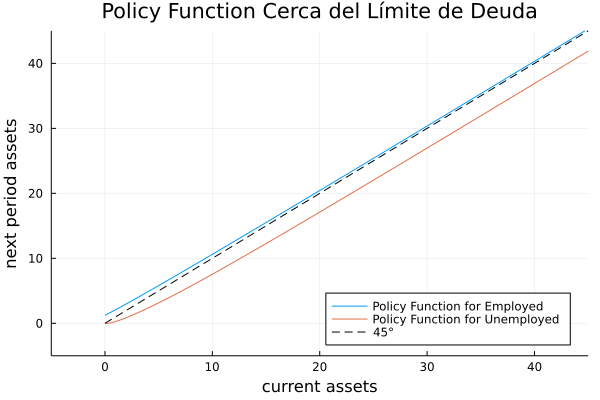

In [71]:
plot(A_grid,g.(A_grid,0),label="Policy Function for Employed")
plot!(A_grid,g.(A_grid,1),label="Policy Function for Unemployed")
plot!(A_grid,x->x,label="45°", color = :black, linestyle = :dash)
plot!(xlabel = "current assets", ylabel = "next period assets", title = "Policy Function Cerca del Límite de Deuda",
    xlim = (-5.0, 45), ylim = (-5.0, 45), legend = :bottomright )

Se puede ver que todos los empleados ahorran un poquito. Si tienen pocos activos ahorrran un poquito más. En cambio, quienes están desempleados se endeudan. Sin embargo, cuando se acercan al límite se endeudan menos, hasta el punto en que en el límite no pueden endeudarse, sino que mantienen su posición y consumen el resto de ingresos, son los llamados agentes "Keynesianos" que luego de haber pagado los intereses e impuestos, consumen todo su ingreso.

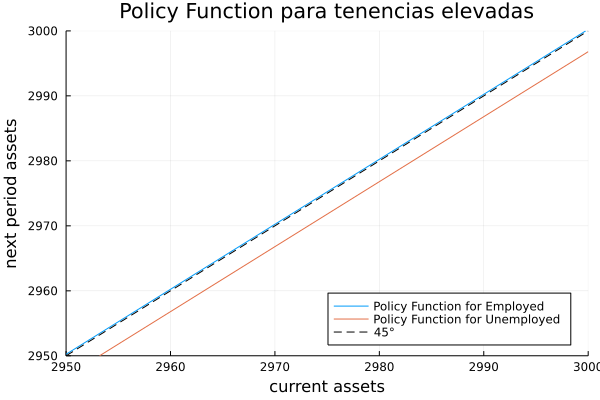

In [72]:
plot(A_grid,g.(A_grid,0),label="Policy Function for Employed")
plot!(A_grid,g.(A_grid,1),label="Policy Function for Unemployed")
plot!(A_grid,x->x,label="45°", color = :black, linestyle = :dash)
plot!(xlabel = "current assets", ylabel = "next period assets", title = "Policy Function para tenencias elevadas",
 xlim = (2950, 3000), ylim = (2950, 3000), legend = :bottomright )

(Some reflection for above figure)

Once we get the policy function next step is to compute the distribution that the policy function implies. For this step I follow [Young 2010](https://www.sciencedirect.com/science/article/abs/pii/S0165188909001316) and [McKay's notes](https://alisdairmckay.com/Notes/HetAgents/Aiyagari.html "McKay - Aiyagari").

To simulate a population of households I am going to use the following approach. Its broad idea is to approximate $f(a,\epsilon)$ with a matrix or one can think as two histograms $f_\epsilon$. To do so we can use the same grid $A$ that we used in EGM. Let $N_A$ be the number of grid points in the asset grid $A$. Then $f$ is a $N_A\times2$ matrix $f$ that assigns a *mass* to each state, (it can thought as a function $m=f_(a,\epsilon)$).

A small challenge with this approach is that the policy rule g(a,e) will not necessarily select values on the grid. For example, if the grid is $[-2,\;-1,\;0,\;1,\;2,\;3,\;4,\;...]$ and the policy function of a household returns a value of $2.25$... Where to allocate the mass of this household? Let say that this household has mass $m$, therefore the intuitive approach is to allocate $0.75m$ to the grid point $2$ and $0.25m$ to the grid point $3$.

$$
y_n = g(x_n)
$$

$$
x_m > y_n > x_{m-1}
$$

$$
y_n = \alpha x_m + (1-\alpha) x_{m-1}
$$

$$
\alpha = \frac{y_n-x_{m-1}}{x_m-x_{m-1}}
$$

$$
g(x_n) = \alpha x_m + (1-\alpha) x_{m-1}
$$

Masa $d$ en $t$ en posición $n$. 

Entonces, en $t+1$:

Masa $d\,\alpha$ en la posición $m$.    Y masa $d\,(1-\alpha)$ en la posición $m-1$.

In [43]:
function allocate_mass(y_n, x_grid, grid_size)
       
    m = searchsortedfirst(x_grid, y_n)  # x_m > y_n > x_{m-1}
    m = min(m, grid_size)  # max = grid size.   If y_n > x_max => the above function returns max+1.  We don't wnat that 
    
    if isone(m)               # if y_n is too small that x_1 > y_n
        return 2, 0           # then we force m=2 and assign 0 weight  ( m-1 = 1 and its weight is 1)
    end
    
    x_m = x_grid[m]
    x_m_1 = x_grid[m-1]
    
    D_x = x_m - x_m_1
    
    peso_m = (y_n - x_m_1) / D_x      
    peso_m = min(max(peso_m, 0.0), 1.0)  # Por las dudas 

    return m, peso_m
end

allocate_mass (generic function with 1 method)

One approach to compute the stationary distribution $f^*$ would be to start from an initial guess and a then apply the following algorithm. 

First we apply the policy function in every state, we get a $N_a\times2$ matrix $G$. As discussed above, some values will be off-grid and we followed the mentioned decision ruled that can be thought as a function $\Omega:\mathbb{R}\rightarrow \mathbb{R}^{A_N}$, it gives a vector where positions correspondig to the two nearest grid points ($\bar{a_{index}}',\underline{a_{index}}'$) the corresponding weights ($\bar{\omega},\underline{\omega}$) and 0 in the rest of the elements.

Second, we take the current distribution $f_n$ and redistributed the current mass $f_n(a,\epsilon)$ to the $f_{n+1}$ distribution to the (four) elements represented by $(a',\epsilon')$ with weight represented by $\omega \pi_{\epsilon'|\epsilon}$.

However we can do better, than iterating. Notice that the above algorithm applies a linear transformation to every value of $f$. Therefore it is possible to think the algorithm in a matrixial fashion. In order to do it appropietly, we have to reshape $f$, that is to construct a vector $F$ that contains the two rows $f$ stacked on top of one another, this implies that $F$ has size $2N_A\times1$). Then, we can create a $2N_A\times2N_A$ transition matrix $T$, that will update the distribution $F$ to $F'$ according to the decripted rule $F′=TF$. That is using the policy function $g$ and the allocation function $\Omega$ to distribute the mass of $F$ to $F'$. 

How to construct $T$? Recall that acordingly to matrix multiplication we know that $D'_i=\sum_{j=1}^{2N_A}T_{i,j}D_{j}$, that implies that $T_{i,j}$ indicates how much of the mass ubicated in $j$ should be tranferred to $i$. Acording to the above discussion for $j\leq N_A$ we have $T_{i,j}=\pi_T(i|e)\Omega(G_j)_i$, where $\pi_T$ is the conditional probability considering $i\leq N_A$ as $e$ or $u$ otherwise.

Thus we can construct $T$, which is a trnasition matrix. Moreover it is a transition matrix of a Markov chain, since it works with discrete distributions, then we can compute the stationary distribution $F^*$, given by the Eigen-vector of $T$ associated with the unit Eigen-value normalized to sum to one.

I used a very simimlar implementation of [Julien Pascal's code](https://julienpascal.github.io/post/aiyagariaggregateuncertainty/) and I found his code very useful.

In [44]:
function transition_mat(g::Function, asset_grid)
    A_N=size(asset_grid)[1];  T = fill(0.0,(2*A_N,2*A_N))
    
    # Loop over savings:
    for n in 1:A_N   
        # Loop over current employment state:
        for ε = 0:1
            
            a = asset_grid[n]

            y_n = g(a,ε) # y_n = g(a,2-e)                   
            m, peso_m = allocate_mass(y_n, asset_grid, A_N)      #  x_m > y_n > x_{m-1}
            
            base_ε = ε*A_N     # base_ε = (e-1)*A_N
            # Loop over the possible next employment states s
            for s = 0:1
                base_s = s*A_N 
                # weight on the grid point above 
                T[base_s+m, base_ε+n] = peso_m * P[ε+1,s+1]
                # weight on the grid point below 
                T[base_s+m-1, base_ε+n] = (1-peso_m) * P[ε+1,s+1] 
            end
        end
    end
    return T
end

transition_mat (generic function with 1 method)

In [73]:
# STEP 4: Computing the stationary distribution

# Finer A grid
#a_n_finer = a_n*3
#A_grid_finer = collect(range(0, stop=(a_max-a_min_0)^(0.5), length=a_n_finer)).^2 .+ a_min_0
#A_mat_finer = repeat(A_grid_finer, outer=[1, 2])'

# Construct transition matrix T
T = transition_mat(g, A_grid)
# η_test = 1e-10/(2*a_n) # For Perron-Frobenius theorem 
#T = transition_mat(G,η_test)

400×400 Matrix{Float64}:
 0.0        0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.9338     0.841705  0.565418  0.104939     0.0        0.0        0.0
 0.0226995  0.114795  0.391082  0.851561  …  0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 0.0        0.0       0.0       0.0          0.0        0.0        0.0
 ⋮                                        ⋱         

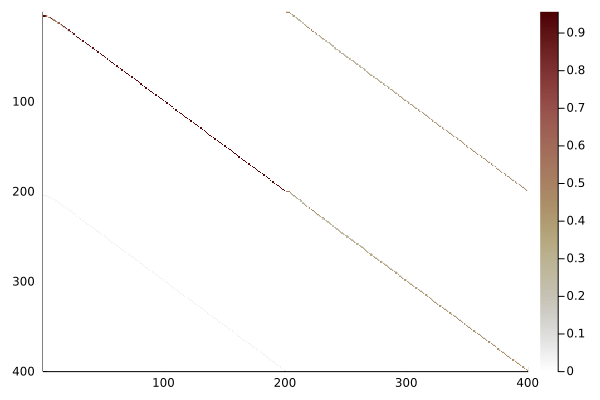

In [74]:
heatmap(T,c=:bilbao,yflip=true)

La fila $i$ me dice quiénes, y en qué proporción tendrán una posición $i$ de activo en el siguiente período.

Hay cuatro cuadrantes:
- nor-oeste estoy empleado hoy y mañana estoy empleado
- sur-oeste estoy empleado hoy y mañana estoy desempleado 
- nor-este estoy desempleado hoy y mañana estoy empleado
- sur-oeste estoy desempleado hoy y mañana estoy desempleado

En la mitad occidental la intensidad del norte es mayor a la del sur porque la probabilidad de perder el empleo es baja
En la mitad oriental la intensidad son las mismas porque la probabilidad de encontrar trabajo es 0.5

(Mostrar una versión con una matriz de 20x20 que se nota mejor la dinámica)

In [47]:
# Function to find the index corresponding to the closest value on a grid:
# Source: https://discourse.julialang.org/t/findnearest-function/4143/4
function nearest(x,grid)
    idx = searchsortedfirst(grid,x)
    if (idx==1); return idx; end
    if (idx>length(grid)); return length(grid); end
    if (grid[idx]==x); return idx; end
    if (abs(grid[idx]-x) < abs(grid[idx-1]-x))
      return idx
    else
      return idx-1
    end
end


nearest (generic function with 1 method)

In [48]:
function stationary_dist(T)
    
    A_N = Int(size(T)[1]/2)

    T_eigen = eigen(T) # eigen values and eigen vectors
    
    eigenvalues_real = real(T_eigen.values) # take the real part of the eigen-values
    
    i = nearest(1.0, eigenvalues_real) # where is the nearest eigen value to 1 ?
    
    eigenvector_real = real(T_eigen.vectors[:,i]) # Select the corresponding eigenvector
    
    F = eigenvector_real/sum(eigenvector_real) # Normalize it
    fe = F[1:A_N]
    fu = F[A_N+1:2*A_N]
    
    return [fe , fu]
    
end

stationary_dist (generic function with 1 method)

In [75]:
# STEP 4: Computing the stationary distribution (most time consuming step)
fe, fu = stationary_dist(T);

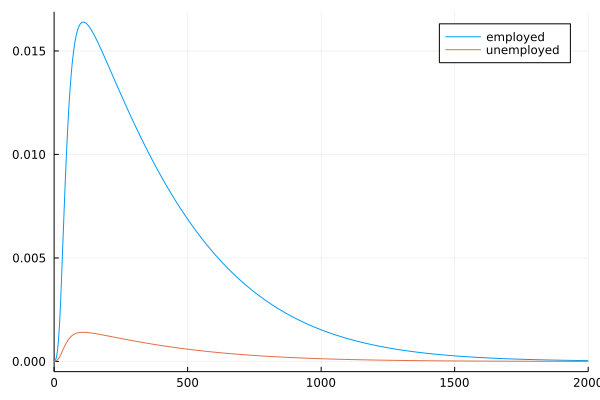

In [76]:
plot(A_grid,fe,label="employed", xlim=(a_min_0,2000))
plot!(A_grid,fu,label="unemployed")

Once we have the stationary distribution we should check if the guessed valued for $K_0$ corresponds with the resulting value for $K_0'$ acording to the distribution.

In [52]:
# STEP 5: Comparing distribution's agreggate K 
@show sum(fe)
@show Nss

K_agg = sum( fe .* A_grid  +  fu .* A_grid  )
@show K_0
@show K_agg;

sum(fe) = 0.919963201471936
Nss = 0.9199632014719411
K_0 = 245.14
K_agg = 246.73066781179915


El capital propuesto es incompatible con la distribución de la riqueza que genera. La tasa de interés no es lo suficientemente atractiva para mantenerlo. Lo esperable sería que haya menos capital agregado, y por en una tasa mayor y una mayor cantidad de capital generado por la distribución.

Para hallar el capital de equilibrio haremos una búsqueda binaria.

### Finding Aggregate Capital

We do it with the Brent Method implemented by ```Omptim``` Package

In [54]:
function Exeso_DK_cuadrado(K_in, a_max, a_n, max_iter, tol)
    
    # Rates
    r_ss = r(K_in); w_ss = w(K_in); b_ss = b(K_in); τ_ss = τ(K_in,b_ss);
    
    # Asset grid
    a_min_ss = a_min(K_in,b_ss)
    A_grid = collect(range(0, stop=(a_max-a_min_ss)^(0.5), length=a_n)).^2 .+ a_min_ss
    A_mat = repeat(A_grid, outer=[1, 2])'
    
    # Policy function
    g_old_ss(a,ε) = max(a,a_min_ss)
    g_new_ss(a,ε) = max(a,a_min_ss)
    A_old_ss = similar(A_mat)
    for it in 1:max_iter
        A_new_ss, g_new_ss = EGM(g_old_ss, r_ss, w_ss, b_ss, τ_ss, a_min_ss, A_mat, A_grid)
        distance_ss = norm(A_new_ss - A_old_ss, Inf)      
        if distance_ss < tol; break; end;
        A_old_ss = copy(A_new_ss) 
        g_old_ss = g_new_ss 
    end
    g_ss = g_new_ss
    
    # Stationary distribution 
    T_ss = transition_mat(g_ss, A_grid)
    fe_ss, fu_ss = stationary_dist(T_ss)
    
    # Agregate Capital
    K_out = sum( fe_ss .* A_grid  +  fu_ss .* A_grid  )

    return 0.5*(K_in - K_out)^2
    
end

Exeso_DK_cuadrado (generic function with 1 method)

In [55]:
@show 0.5*(K_0 - K_agg)^2

a_max = 3000
a_n = 200
max_iter=2000
tol=1e-10
K_ej = K_0

# Checkeo
Exeso_DK_cuadrado(K_ej, a_max, a_n, max_iter, tol)

0.5 * (K_0 - K_agg) ^ 2 = 1.2651120437469714


1.2651120437469714

In [56]:
@time eq_stacionario = optimize(K -> Exeso_DK_cuadrado(K, a_max, a_n, max_iter, tol), 200, 300, Brent())
K_ss = eq_stacionario.minimizer
println("Steady-state value of capital K* = $(K_ss)")

 18.462755 seconds (106.32 M allocations: 4.872 GiB, 3.85% gc time, 0.70% compilation time)
Steady-state value of capital K* = 245.1464679358777


r_ss = r(K_ss) = 0.005089814520572726
w_ss = w(K_ss) = 4.779867306554993
b_ss = b(K_ss) = 1.2236460304780783
τ_ss = τ(K_ss) = 0.017349124398921896
a_min_ss = a_min(K_ss) = 0.0
β * (1 + r_0 * (1 - τ_ss)) = 0.9999766697264474
sum(fe) = 0.919963201471936
Nss = 0.9199632014719411
K_ss = 245.1464679358777
K_agg = 245.1467622963869


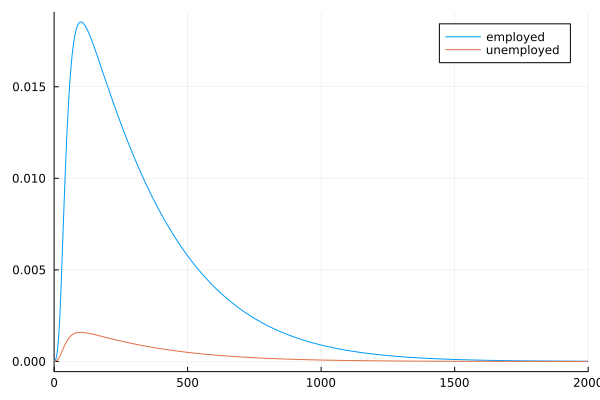

In [57]:
# Stationary Equilibrium Prices
@show r_ss = r(K_ss)
@show w_ss = w(K_ss)
@show b_ss = b(K_ss)
@show τ_ss = τ(K_ss)
@show a_min_ss = a_min(K_ss)
@show β*(1+r_0*(1-τ_ss))
;

# SS policy function
g_0(a,ε) = max(a,a_min_ss)
max_iter=2000
tol=1e-10
g_old = g_0
A_old = similar(A_mat)
for it in 1:max_iter
    global A_new, g_new = EGM(g_old, r_ss, w_ss, b_ss, τ_ss, a_min_ss, A_mat, A_grid)
    distance = norm(A_new - A_old, Inf)      #maximum(abs.(A_new - A_old)) 
    if distance < tol ;   break;    end      # Check for convergence
    A_old = copy(A_new) 
    g_old = g_new 
end
g_ss = g_new

# SS Distribution
T_ss = transition_mat(g_ss, A_grid)
fe_ss, fu_ss = stationary_dist(T_ss)
@show sum(fe)
@show Nss
K_agg = sum( fe_ss .* A_grid  +  fu_ss .* A_grid  )
@show K_ss
@show K_agg;
plot(A_grid,fe_ss,label="employed", xlim=(a_min_ss,2000))
plot!(A_grid,fu_ss,label="unemployed")
